## Installlibraries

In [ ]:
! pip install chembl_webresource_client
! conda install -c rdkit rdkit -y

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.2 MB/s eta 0:00:00
/bin/bash: line 1: conda: command not found


In [ ]:
!pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.4 MB/s eta 0:00:00


## Import libraries

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from rdkit.Chem.MolStandardize import rdMolStandardize
from chembl_webresource_client.new_client import new_client
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

## Buat Targer IDO1

In [ ]:
target = new_client.target
target_query = target.search('IDO1')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,"Indoleamine 2,3-dioxygenase",17.0,False,CHEMBL4685,"[{'accession': 'P14902', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Mus musculus,"Indoleamine 2,3-dioxygenase 1",17.0,False,CHEMBL1075294,"[{'accession': 'P28776', 'component_descriptio...",SINGLE PROTEIN,10090
2,[],Rattus norvegicus,"Indoleamine 2,3-dioxygenase 1",17.0,False,CHEMBL4523451,"[{'accession': 'Q9ERD9', 'component_descriptio...",SINGLE PROTEIN,10116
3,[],Homo sapiens,IDO1/VHL,17.0,False,CHEMBL5169061,"[{'accession': 'P14902', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
4,[],Mus musculus,Ido1/Crbn,17.0,False,CHEMBL5169091,"[{'accession': 'P28776', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,10090
5,[],Homo sapiens,"Cereblon/Indoleamine 2,3-dioxygenase 1",16.0,False,CHEMBL4742272,"[{'accession': 'P14902', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606


### Pilih dan ambil data bioaktivitas untuk IDO1

In [ ]:
selected_target = targets.target_chembl_id[1]
selected_target

'CHEMBL1075294'

### Ekstraksi data IC50

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

### Mengonversi data ke dalam bentuk dataframe

In [ ]:
df = pd.DataFrame.from_dict(res)
df.head(3)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,2927828,[],CHEMBL1042998,"Inhibition of indoleamine 2,3-dioxygenase in m...",B,None,None,BAO_0000190,...,Mus musculus,"Indoleamine 2,3-dioxygenase 1",10090,None,None,IC50,nM,UO_0000065,None,46.0
1,None,None,2927834,[],CHEMBL1043006,"Inhibition of indoleamine 2,3-dioxygenase in m...",B,None,None,BAO_0000190,...,Mus musculus,"Indoleamine 2,3-dioxygenase 1",10090,None,None,IC50,uM,UO_0000065,None,1.0
2,None,None,2988410,[],CHEMBL1040015,Inhibition of mouse recombinant IDO expressed ...,B,None,None,BAO_0000190,...,Mus musculus,"Indoleamine 2,3-dioxygenase 1",10090,None,None,IC50,uM,UO_0000065,None,20.0


In [ ]:
df.standard_type.unique()

array(['IC50'], dtype=object)

## Menangani data yang hilang

In [ ]:
df = df[df.standard_value.notna()]

## Data pre-processing bioactivity

### Pemberian Label pada Senyawa: Aktif, Tidak Aktif, atau Intermediate  
Data bioaktivitas berada dalam satuan IC50. Pemberian label dilakukan dengan kriteria berikut:  

1. **Aktif:** Senyawa dengan nilai IC50 kurang dari 1.000 nM.  
2. **Tidak Aktif:** Senyawa dengan nilai IC50 lebih dari 10.000 nM.  
3. **Intermediate:** Senyawa dengan nilai IC50 di antara 1.000 dan 10.000 nM.  

In [ ]:
df['standard_value'] = df['standard_value'].astype(float)
df['bioactivity_class'] = df['standard_value'].map(lambda x : 'active' if x <= 1000 else ('inactive' if x >=10000 else 'intermediate'))

In [ ]:
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value','bioactivity_class']
df = df[selection]
df.head(5)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL584991,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,46.0,active
1,CHEMBL584991,Nc1nonc1/C(=N/O)Nc1ccc(F)c(Cl)c1,1000.0,active
2,CHEMBL571436,Sc1nc(-c2ccccc2)cs1,20000.0,inactive
3,CHEMBL193664,c1ccc(-c2cnn[nH]2)cc1,5000.0,intermediate
7,CHEMBL449298,Nc1ccc(O)c2ncccc12,1000.0,active


df.canonical_smiles.replace('nan',np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index(inplace=True)

In [ ]:
'''
function to estimate molecule Lipinski descriptors

'''

def lipinski(smiles, verbose=False):
    moldata= []
    problematic_smiles=[]
    for i,elem in enumerate(smiles):
        try:
            mol=Chem.MolFromSmiles(elem)
            mol = rdMolStandardize.Cleanup(mol)
            moldata.append(mol)
        except:
            problematic_smiles.append(i)
            pass
    baseData= np.arange(1,1)
    i=0
    for mol in moldata:
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return  descriptors,problematic_smiles

In [ ]:
df_lipinski, problematic_smiles = lipinski(df.canonical_smiles)

[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Normalizer
[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Normalizer
[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Normalizer
[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Normalizer
[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Normalizer
[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Normalizer
[03:40:50] Initializing MetalDisconnector
[03:40:50] Running MetalDisconnector
[03:40:50] Initializing Normalizer
[03:40:50] Running Nor

In [ ]:
df_lipinski.head(10).style.background_gradient()

,MW,LogP,NumHDonors,NumHAcceptors
0,271.639000,1.692200,3.000000,6.000000
1,271.639000,1.692200,3.000000,6.000000
2,193.296000,3.098800,1.000000,3.000000
3,145.165000,1.471700,1.000000,2.000000
4,160.176000,1.522600,2.000000,3.000000
5,160.172000,2.251000,2.000000,2.000000
6,187.242000,2.977200,2.000000,2.000000
7,201.269000,3.365700,2.000000,2.000000
8,396.490000,5.027200,0.000000,4.000000
9,452.598000,6.587600,0.000000,4.000000


In [ ]:
df = pd.concat([df,df_lipinski], axis=1)

### Konversi IC50 ke pIC50  
Untuk membuat data **IC50** lebih terdistribusi secara seragam, kita akan mengonversi **IC50** ke skala logaritmik negatif, yaitu **-log10(IC50)**.  

Fungsi khusus `pIC50()` akan menerima DataFrame sebagai input dan akan:  
* Mengambil nilai IC50 dari kolom ``standard_value`` dan mengonversinya dari nM ke M dengan mengalikan nilai tersebut dengan \(10^{-9}\).  
* Mengambil nilai molar dan menerapkan -log10.  
* Menghapus kolom ``standard_value`` dan membuat kolom baru bernama ``pIC50``.  

In [ ]:
def pIC50(i):
    molar = i*(10**-9) # Converts nM to M
    pIC50 = -np.log10(molar)
    return pIC50

**Catatan :**  
Nilai IC50 yang lebih besar dari 100.000.000 akan ditetapkan menjadi 100.000.000, karena jika tidak, nilai logaritmik negatifnya akan menjadi negatif.

In [ ]:
df.standard_value.describe()

,standard_value
count,159.000000
mean,14672.590566
std,46931.527802
min,1.000000
25%,28.500000
50%,150.000000
75%,1900.000000
max,400000.000000


In [ ]:
df['norm_value'] = df['standard_value'].map(lambda x: 100000000 if x> 100000000 else x)
df['pIC50'] = df['norm_value'].map(pIC50)

### Menghapus Kelas Bioaktivitas 'Intermediate'  
Pada bagian ini, kelas ``intermediate`` akan dihapus dari dataset.  

In [ ]:
df = df[df['bioactivity_class'] != 'intermediate']

In [ ]:
df['bioactivity_class'].value_counts()

,count
bioactivity_class,
active,110
inactive,32


## Analisis Data Eksploratif (Analisis Ruang Kimia) melalui Deskriptor Lipinski  

Analisis eksploratif dilakukan untuk memahami karakteristik kimiawi senyawa menggunakan deskriptor Lipinski. Deskriptor ini mencakup:  
1. **Berat Molekul (Molecular Weight)**: Memberikan informasi tentang ukuran molekul.  
2. **LogP**: Mengukur kelipofilan molekul (keseimbangan antara hidrofilik dan hidrofobik).  
3. **Donor Ikatan Hidrogen (H-bond Donors)**: Jumlah atom hidrogen yang dapat berpartisipasi dalam pembentukan ikatan hidrogen.  
4. **Penerima Ikatan Hidrogen (H-bond Acceptors)**: Jumlah atom yang dapat menerima ikatan hidrogen.  
5. **Ikatan Rotasi (Rotatable Bonds)**: Jumlah ikatan tunggal yang dapat berputar dalam molekul, memengaruhi fleksibilitas struktur.  

 Tujuan  
- Memvisualisasikan distribusi deskriptor ini untuk senyawa dalam dataset.  
- Memahami karakteristik kimia senyawa yang termasuk dalam kelas bioaktivitas tertentu (aktif atau tidak aktif).  

Langkah-Langkah  
1. **Estimasi Deskriptor Lipinski:** Menggunakan fungsi yang telah didefinisikan sebelumnya untuk menghitung deskriptor untuk setiap molekul.  
2. **Visualisasi Distribusi:** Membuat histogram, boxplot, atau scatterplot untuk melihat pola distribusi dari masing-masing deskriptor.  
3. **Analisis Komparatif:** Membandingkan karakteristik deskriptor antara senyawa aktif dan tidak aktif.  

Hasil yang Diharapkan  
- Identifikasi pola distribusi deskriptor yang signifikan.  
- Pemahaman yang lebih baik tentang ruang kimia (chemical space) dari dataset.  
- Informasi untuk mendukung desain senyawa baru dengan aktivitas yang diinginkan.  

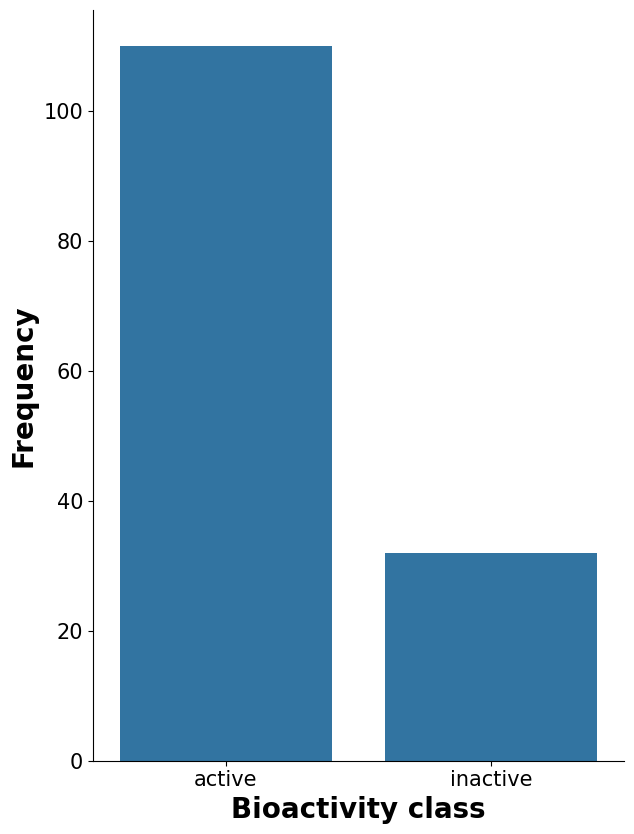

In [ ]:
plt.figure(figsize=(6.5, 8.5))

sns.countplot(x='bioactivity_class', data=df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Frequency', fontsize=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.set(style='ticks')
sns.despine(top=True)
plt.tight_layout()
plt.savefig('plot_bioactivity_class.png')

Berdasarkan grafik histogram, dapat disimpulkan bahwa jumlah senyawa yang termasuk dalam kelas bioaktivitas aktif jauh lebih banyak dibandingkan dengan kelas tidak aktif. Ini menunjukkan bahwa dataset memiliki distribusi data yang tidak seimbang, dengan dominasi senyawa dalam kelas aktif.

### Pairplot Fitur  

Dapat dilihat bahwa kedua kelas bioaktivitas mencakup ruang kimia yang serupa, sebagaimana terlihat pada scatter plot antara MW (Molecular Weight) dan LogP.  

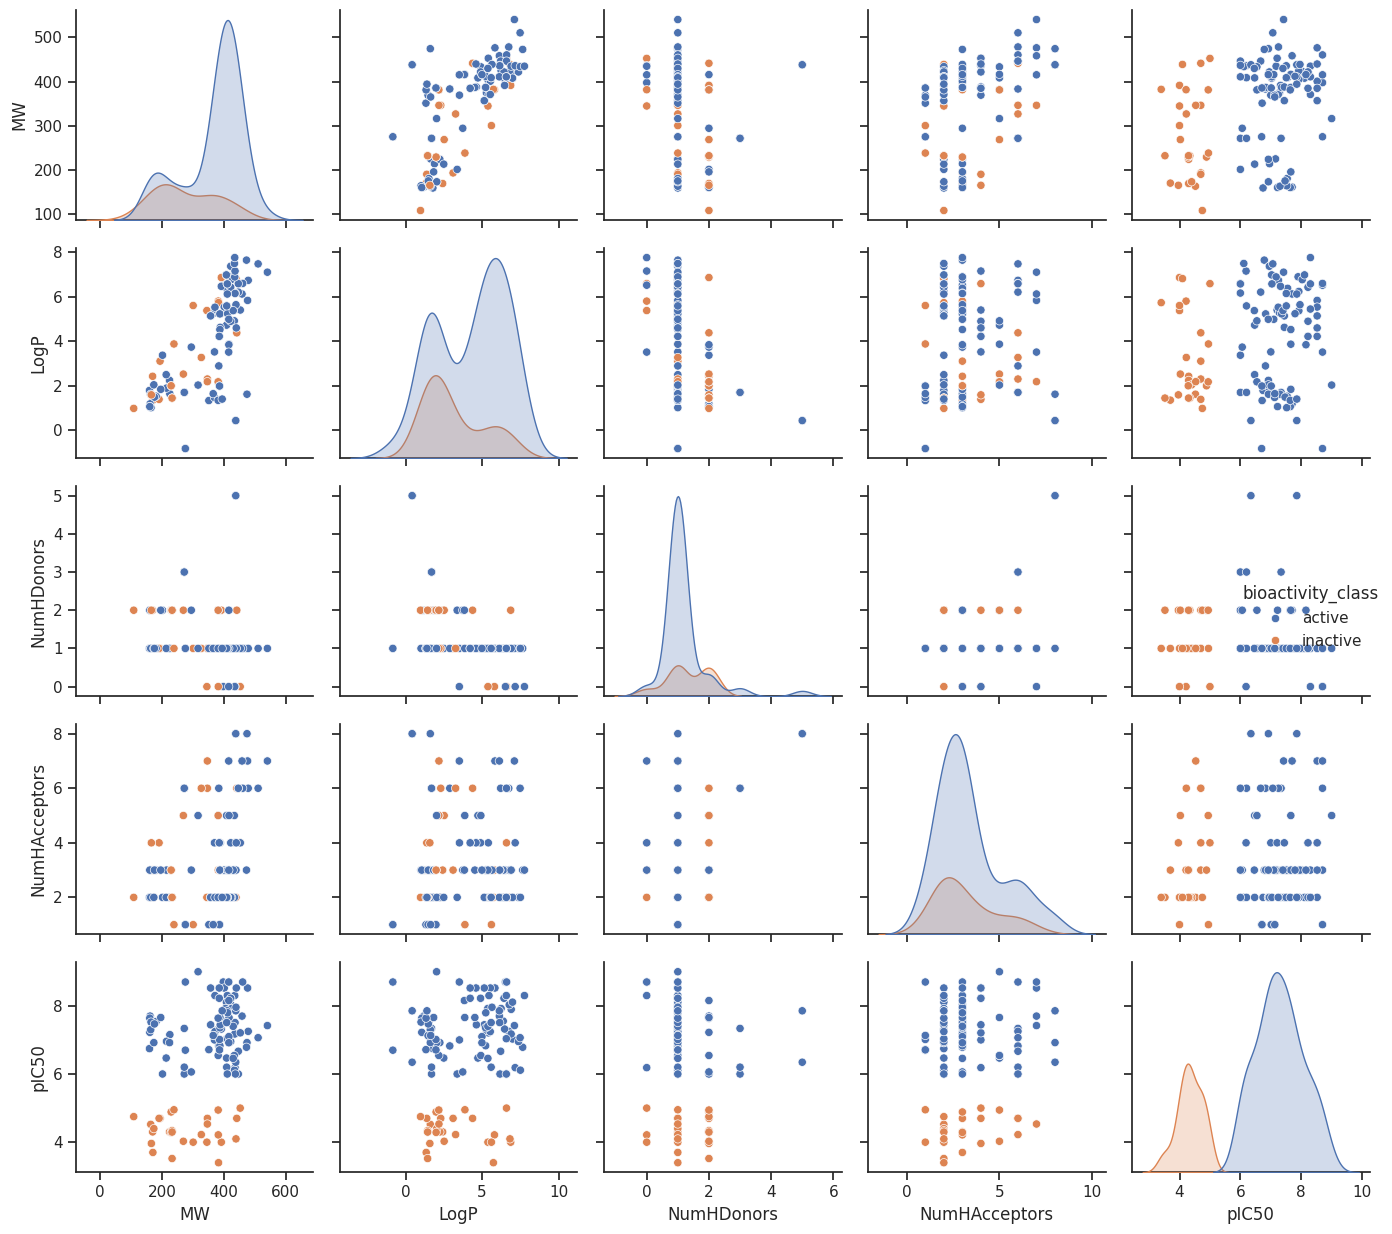

In [ ]:
selection = ['bioactivity_class','MW','LogP','NumHDonors','NumHAcceptors','pIC50']
sns.pairplot(df[selection], hue='bioactivity_class')
plt.tight_layout()
plt.savefig('Pairplot.png',dpi=300)

Berdasarkan pairplot yang ditampilkan, dapat disimpulkan sebagai berikut:

1. **Distribusi Kelas Bioaktivitas:**  
   Kedua kelas bioaktivitas, yaitu **aktif** dan **tidak aktif**, memiliki distribusi yang cukup serupa di ruang kimia, sebagaimana terlihat pada hubungan antar fitur seperti MW (Molecular Weight) dan LogP.

2. **Hubungan Antar Fitur:**  
   - Ada korelasi yang terlihat antara MW dan LogP, di mana nilai yang lebih tinggi dari MW cenderung sejalan dengan nilai LogP yang lebih tinggi.
   - Fitur-fitur seperti NumHDonors (jumlah donor H) dan NumHAcceptors (jumlah akseptor H) menunjukkan distribusi yang lebih terpisah, tetapi masih mencakup kelas bioaktivitas yang saling tumpang tindih.

3. **pIC50:**  
   Fitur pIC50 memperlihatkan distribusi yang lebih bervariasi untuk senyawa aktif, sementara untuk senyawa tidak aktif, nilai pIC50 cenderung lebih rendah.

Implikasi:
- Sebagian besar fitur menunjukkan tumpang tindih antara kelas aktif dan tidak aktif, yang mungkin menyulitkan pemisahan menggunakan metode klasifikasi sederhana.
- Analisis lebih lanjut seperti pemilihan fitur atau penggunaan algoritma non-linear mungkin diperlukan untuk meningkatkan pemisahan antar kelas.

### Boxplot pIC50

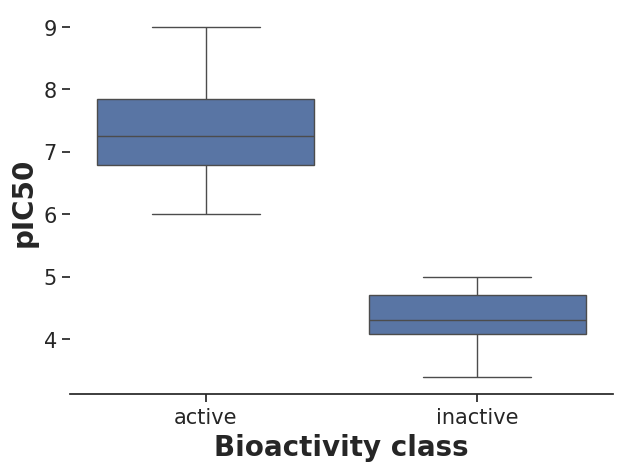

In [ ]:
fig = plt.figure(figsize=(7,5))
sns.boxplot(x='bioactivity_class', y='pIC50', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('pIC50', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine(top=True, left=True)
plt.savefig('boxplot_pIC50.png',dpi=300);

Berdasarkan boxplot yang ditampilkan, dapat disimpulkan sebagai berikut:

1. **Distribusi pIC50:**
   - Senyawa dalam kelas **aktif** memiliki nilai pIC50 yang lebih tinggi secara konsisten, dengan median sekitar 7-8.
   - Senyawa dalam kelas **tidak aktif** memiliki nilai pIC50 yang lebih rendah, dengan median sekitar 4-5.

2. **Rentang Nilai:**
   - Kelas **aktif** menunjukkan rentang pIC50 yang lebih luas dibandingkan kelas **tidak aktif**.
   - Tidak terdapat tumpang tindih signifikan antara kedua kelas, menunjukkan bahwa pIC50 merupakan indikator yang cukup baik untuk memisahkan kelas bioaktivitas.

Implikasi:
- Nilai pIC50 dapat digunakan sebagai fitur yang kuat untuk klasifikasi senyawa menjadi kelas **aktif** atau **tidak aktif**.
- Model klasifikasi yang dibangun dengan fitur pIC50 memiliki potensi untuk memberikan prediksi yang akurat.

### Boxplot  Lipinksi descriptors

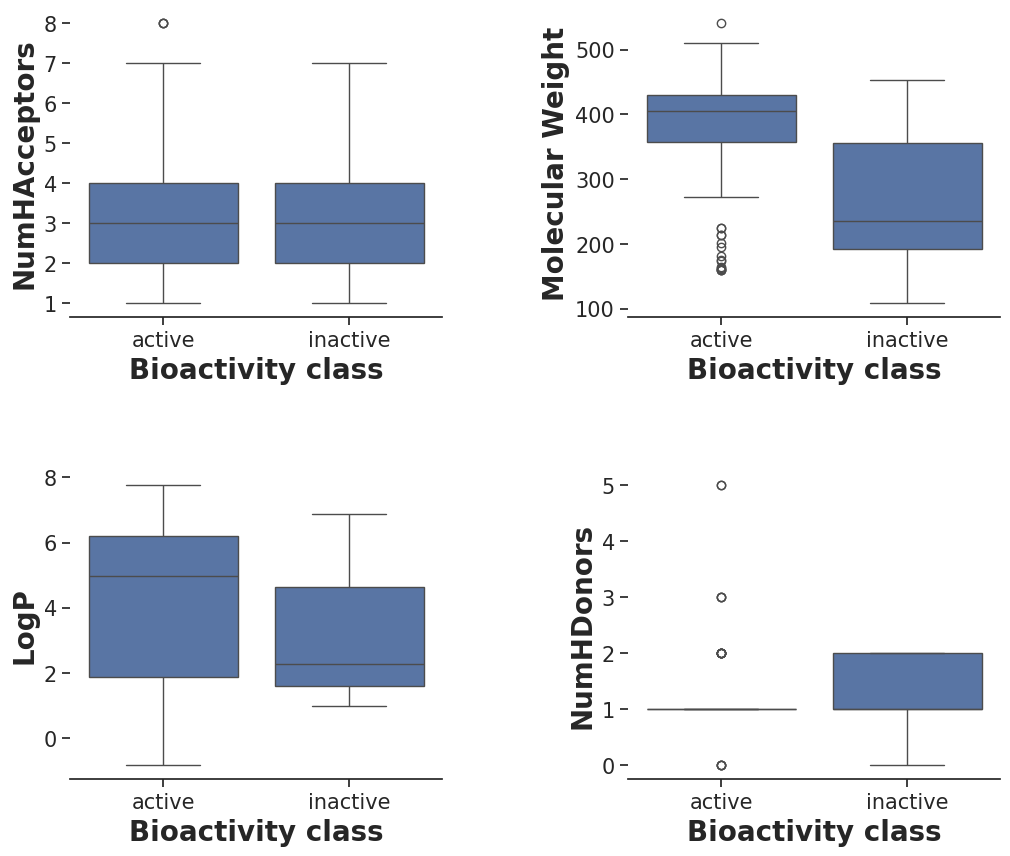

In [ ]:
fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.5,wspace=0.5)
fig.add_subplot(2,2,1)
sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHAcceptors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,2)
sns.boxplot(x='bioactivity_class', y='MW', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('Molecular Weight', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,3)
sns.boxplot(x='bioactivity_class', y='LogP', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('LogP', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

fig.add_subplot(2,2,4)
sns.boxplot(x='bioactivity_class', y='NumHDonors', data = df)
plt.xlabel('Bioactivity class', size=20, fontweight='bold')
plt.ylabel('NumHDonors', size=20, fontweight='bold')
plt.xticks(size=15)
plt.yticks(size=15)

sns.despine(top=True, left=True)
plt.savefig('boxplot_lipinksi_descriptors.png',dpi=300);

Berdasarkan empat boxplot yang ditampilkan, berikut adalah analisisnya:

1. **NumHAcceptors (Jumlah Akseptor Hidrogen):**
   - Distribusi antara kelas **aktif** dan **tidak aktif** relatif mirip.
   - Median dan rentang nilai untuk kedua kelas tidak menunjukkan perbedaan yang signifikan.

2. **Molecular Weight (Berat Molekul):**
   - Kelas **aktif** memiliki berat molekul yang lebih tinggi dibandingkan dengan kelas **tidak aktif**.
   - Median kelas **aktif** berada di sekitar 400, sementara median kelas **tidak aktif** lebih rendah, di bawah 300.
   - Terdapat beberapa outlier dengan berat molekul rendah pada kelas **aktif**.

3. **LogP (Lipofilisitas):**
   - Kelas **aktif** menunjukkan nilai LogP yang lebih tinggi secara keseluruhan, dengan median sekitar 5-6.
   - Kelas **tidak aktif** memiliki nilai LogP yang lebih rendah, dengan median sekitar 2-3.
   - Perbedaan distribusi ini cukup jelas, menunjukkan bahwa LogP dapat menjadi fitur pembeda yang baik.

4. **NumHDonors (Jumlah Donor Hidrogen):**
   - Sebagian besar senyawa pada kelas **aktif** memiliki jumlah donor hidrogen yang rendah (di bawah 2).
   - Kelas **tidak aktif** menunjukkan distribusi yang serupa, meskipun lebih sempit.

Kesimpulan:
- **LogP** dan **Molecular Weight** adalah fitur yang paling berbeda antara kedua kelas bioaktivitas dan berpotensi menjadi prediktor yang baik.
- **NumHAcceptors** dan **NumHDonors** menunjukkan distribusi yang lebih serupa antara kedua kelas, sehingga mungkin memiliki kontribusi yang lebih kecil untuk pemisahan kelas.

## Statistical analysis | Mann-Whitney U Test

In [ ]:
def mannwhitney_(active,inactive, descriptor):
  stat, p = mannwhitneyu(active,inactive)
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [ ]:
for feature in selection[1:]:
    results=mannwhitney_(df[df['bioactivity_class'] != 'inactive'][feature],
                df[df['bioactivity_class'] ==  'inactive'][feature],
                feature)
    display(results)

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,NaN,NaN,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,NaN,NaN,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,NaN,NaN,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,NaN,NaN,0.05,Different distribution (reject H0)


,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,NaN,NaN,0.05,Different distribution (reject H0)


In [ ]:
df.to_csv('IDO1.csv')

## Kesimpulan

### Kesimpulan dari Analisis Data Eksploratif (EDA)

Berdasarkan hasil analisis eksploratif data bioaktivitas, dapat disimpulkan:

1. **Distribusi Kelas Bioaktivitas:**
   - Kelas **aktif** memiliki jumlah senyawa yang lebih dominan dibandingkan kelas **tidak aktif**, menunjukkan distribusi data yang tidak seimbang.

2. **pIC50:**
   - Kelas **aktif** memiliki nilai pIC50 yang lebih tinggi dengan median sekitar 7-8, sedangkan kelas **tidak aktif** memiliki median sekitar 4-5. Hal ini menunjukkan bahwa pIC50 merupakan fitur yang baik untuk membedakan kelas bioaktivitas.

3. **Deskriptor Lipinski:**
   - **Molecular Weight (MW):** Kelas **aktif** cenderung memiliki berat molekul yang lebih tinggi dibandingkan kelas **tidak aktif**, dengan median kelas aktif sekitar 400.
   - **LogP:** Kelas **aktif** memiliki nilai LogP yang lebih tinggi (median 5-6) dibandingkan kelas **tidak aktif** (median 2-3). LogP menunjukkan perbedaan yang signifikan antara kedua kelas dan berpotensi menjadi prediktor yang baik.
   - **NumHAcceptors dan NumHDonors:** Kedua deskriptor ini menunjukkan distribusi yang serupa antara kelas **aktif** dan **tidak aktif**, sehingga kontribusinya terhadap pemisahan kelas mungkin lebih kecil.

4. **Ruang Kimia (Chemical Space):**
   - Kedua kelas bioaktivitas mencakup ruang kimia yang cukup mirip, meskipun beberapa fitur seperti MW dan LogP menunjukkan pola distribusi yang dapat digunakan untuk klasifikasi.

Implikasi:
- Fitur **pIC50**, **LogP**, dan **Molecular Weight** dapat menjadi indikator yang kuat dalam membedakan kelas bioaktivitas.
- Ketidakseimbangan data perlu diperhatikan saat membangun model klasifikasi, dengan mempertimbangkan teknik penyeimbangan data.
